### TOC

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import functools
import json
import matplotlib.pyplot as plt
import itertools
import os
import re
import pickle
import joblib
import json
import pathlib
import typing as t
import datetime
import tqdm.notebook as tqdm
import dataclasses
import ipdb
import warnings
import pickle
import logging
import copy
import math
import pprint

In [3]:
import sklearn
import sklearn.metrics

In [4]:
import IPython.display 

In [5]:
warnings.filterwarnings(action='ignore', category=UserWarning)

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['savefig.dpi'] = 80

In [8]:
# https://matplotlib.org/stable/tutorials/introductory/usage.html#what-is-interactive-mode
plt.ioff();

# dataset

In [9]:
df = pd.read_csv('data/heart_statlog_cleveland_hungary_final.csv.gz', sep=',', low_memory=False)

In [10]:
df.sample(10)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
940,44,1,2,130,219,0,2,188,0,0.0,1,0
934,50,1,4,150,243,0,2,128,0,2.6,2,1
1047,46,1,2,101,197,1,0,156,0,0.0,1,0
167,50,1,4,140,231,0,1,140,1,5.0,2,1
1165,57,1,2,154,232,0,2,164,0,0.0,1,1
772,46,0,2,105,204,0,0,172,0,0.0,1,0
400,61,1,3,200,0,1,1,70,0,0.0,2,1
801,53,1,3,130,246,1,2,173,0,0.0,1,0
1107,41,0,3,112,268,0,2,172,1,0.0,1,0
32,54,1,4,125,224,0,0,122,0,2.0,2,1


In [11]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
chest pain type,1190.0,3.232773,0.935480,1.0,3.0,4.0,4.00,4.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
resting ecg,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.00,2.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2


# split to train and set

In [13]:
df_trn, df_tst = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

In [14]:
len(df_trn)

952

In [15]:
len(df_tst)

238

# model

In [16]:
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.nn.init
import torch.cuda
import torch.utils.data
import torch.optim
import torch.optim.lr_scheduler
import torch.utils.tensorboard

## event dataset

In [17]:
@dataclasses.dataclass(frozen=True)
class SampleRow:
    
    data: pd.Series

In [18]:
@dataclasses.dataclass(frozen=True)
class SampleBatch:

    size: int

    features: torch.FloatTensor
    
    targets: torch.FloatTensor

In [19]:
class SampleDataset(torch.utils.data.Dataset):

    FEATURES: t.List[str] = [
        'age', 'sex', 'chest pain type', 'resting bp s', 
        'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 
        'exercise angina', 'oldpeak', 'ST slope',
    ]
    
    def __init__(self, df: pd.DataFrame, device: torch.device):
        super(SampleDataset).__init__()

        self.df = df
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> SampleRow:
        return SampleRow(data=self.df.iloc[idx])

    def loader(self, batch_size: int = 1024) -> torch.utils.data.DataLoader:
        return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn=self.collate)

    def load(self, 
             batch_size: int = 1024, 
             title: str = 'procesing', 
             report: t.Optional[t.Callable[[], None]] = None,
            ) -> t.Iterator[SampleBatch]:
        loader: torch.utils.data.DataLoader = self.loader(batch_size)

        with tqdm.tqdm(total=len(self.df), desc=title, mininterval=30, maxinterval=120) as pbar:
            for batch in loader:
                yield batch

                if pbar.update(batch.size):
                    if report:
                        report()

            if report:
                report()
        
    def collate(self, batch: t.List[SampleRow]) -> SampleBatch:
        features: t.List[t.List[float]] = [row.data[self.FEATURES].astype(float).values for row in batch]
        targets: t.List[float] = [float(row.data['target']) for row in batch]

        # convert sample bean into a map of tensors
        return SampleBatch(
            size=len(batch),
            features=torch.FloatTensor(features).to(self.device),
            targets=torch.FloatTensor(targets).to(self.device),
        )

## dataset example

In [20]:
example_dataset = SampleDataset(df, device=torch.device('cpu:0'))

In [21]:
example_dataloader = example_dataset.loader(batch_size=5)

In [22]:
example_batch = next(iter(example_dataloader))

In [23]:
pprint.pprint(example_batch, indent=4, width=120)

SampleBatch(size=5,
            features=tensor([[ 59.0000,   1.0000,   4.0000, 124.0000, 160.0000,   0.0000,   0.0000,
         117.0000,   1.0000,   1.0000,   2.0000],
        [ 51.0000,   0.0000,   2.0000, 160.0000, 194.0000,   0.0000,   0.0000,
         170.0000,   0.0000,   0.0000,   1.0000],
        [ 35.0000,   0.0000,   1.0000, 120.0000, 160.0000,   0.0000,   1.0000,
         185.0000,   0.0000,   0.0000,   1.0000],
        [ 41.0000,   1.0000,   4.0000, 110.0000, 172.0000,   0.0000,   2.0000,
         158.0000,   0.0000,   0.0000,   1.0000],
        [ 59.0000,   1.0000,   3.0000, 125.0000,   0.0000,   1.0000,   0.0000,
         175.0000,   0.0000,   2.6000,   2.0000]]),
            targets=tensor([1., 0., 0., 1., 1.]))


## event model

In [24]:
class SampleModel(torch.nn.Module):

    DIMENSION_INPUT = len(SampleDataset.FEATURES)

    DIMENSION_HIDDEN_1 = 16

    DIMENSION_HIDDEN_2 = 8

    DIMENSION_OUTPUT = 1

    def __init__(self):
        super(SampleModel, self).__init__()

        # hidden layers
        self.fc = torch.nn.Sequential(
            # layer 1
            self.make_linear(self.DIMENSION_INPUT, self.DIMENSION_HIDDEN_1),
            torch.nn.BatchNorm1d(self.DIMENSION_HIDDEN_1),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.5),
            # layer 2
            self.make_linear(self.DIMENSION_HIDDEN_1, self.DIMENSION_HIDDEN_2),
            torch.nn.BatchNorm1d(self.DIMENSION_HIDDEN_2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.5),
            # output
            self.make_linear(self.DIMENSION_HIDDEN_2, self.DIMENSION_OUTPUT),
        )

    @classmethod
    def make_linear(cls, in_size: int, out_size: int) -> torch.nn.Module: 
        layer: torch.nn.Module = torch.nn.Linear(in_size, out_size)
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)
        return layer        
        
    def forward(self, batch: SampleBatch) -> torch.Tensor:
        return self.fc(batch.features)

In [25]:
class SampleModelLoss:

    def __init__(self,
                 summary_metric: str = 'loss/unknown',
                 summary_writer: t.Optional[torch.utils.tensorboard.SummaryWriter] = None
                ):
        self.summary_metric = summary_metric
        self.summary_writer = summary_writer
        
        self.loss: float = 0.0
        self.rows: int = 0

        self.x: t.List[int] = []
        self.y: t.List[float] = []

    def update(self, loss: float, batch_size: int):
        self.rows += batch_size
        self.loss += loss * batch_size
        
    def report(self, epoch: int, step: int, reset: bool = True):        
        if self.rows > 0:
            avg_loss = self.loss / self.rows
        else:
            avg_loss = 0.0
        
        print('epoch {}, step {}, loss: {}'.format(epoch, step, avg_loss))

        if self.summary_writer:
            self.summary_writer.add_scalar(self.summary_metric, avg_loss, step)

        self.x.append(step)
        self.y.append(avg_loss)

        if reset:
            self.loss = 0.0
            self.rows = 0

In [26]:
class SampleModelManager:

    def __init__(self, device: torch.device, lr: float = 0.001):
        self.model: SampleModel = SampleModel()
        self.model.to(device)

        if device.type == 'cuda':
            if torch.cuda.get_device_properties(device.index).multi_processor_count >= 80:
                self.model.compile()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.90)
        
        self.criterion = torch.nn.BCEWithLogitsLoss()

        self.trn_dataset: SampleDataset = SampleDataset(df_trn, device=device)
        self.tst_dataset: SampleDataset = SampleDataset(df_tst, device=device)
        
        self.tag_time: datetime.datetime = datetime.datetime.now()
        self.tag_name: str = self.tag_time.strftime("%Y%m%d-%H%M%S")
        
        self.summary = torch.utils.tensorboard.SummaryWriter(log_dir=f'runs/{self.tag_name}', flush_secs=30)

        self.train_epoch = 0
        self.train_step = 0

        self.trn_loss: SampleModelLoss = SampleModelLoss('loss/trn', self.summary)
        self.tst_loss: SampleModelLoss = SampleModelLoss('loss/tst', self.summary)
    
    def train(self):
        self.model.train()

        batches: t.Iterator[SampleBatch] = self.trn_dataset.load(
            batch_size=256,
            title='training',
            report=lambda: self.trn_loss.report(self.train_epoch, self.train_step),
        )

        for batch in batches:
            outputs = self.model(batch)

            self.optimizer.zero_grad()

            loss = self.criterion(outputs[:, 0], batch.targets)
            loss.backward()

            self.optimizer.step()

            self.trn_loss.update(loss.item(), batch.size)

            self.train_step += batch.size
        
    def test(self):
        self.model.eval()

        batches: t.Iterator[SampleBatch] = self.tst_dataset.load(
            batch_size=256, 
            title='testing',
        )

        with torch.no_grad():
            for batch in batches:
                outputs = self.model(batch)
                
                loss = self.criterion(outputs[:, 0], batch.targets)
                
                self.tst_loss.update(loss.item(), batch.size)

        self.tst_loss.report(self.train_epoch, self.train_step)

    def sample(self, limit: int) -> t.Tuple[t.List[float], t.List[float]]:
        self.model.eval()

        actual: t.List[float] = []
        predicted: t.List[float] = []

        batches: t.Iterator[SampleBatch] = self.tst_dataset.loader(batch_size=1024)
        
        with torch.no_grad():
            for batch in batches:
                outputs = self.model(batch)
                classes = torch.sigmoid(outputs[:, 0])

                actual.extend(batch.targets.cpu().numpy())
                predicted.extend(classes.cpu().numpy())

                if len(actual) >= limit:
                    break

        return actual[:limit], predicted[:limit]
    
    def loop(self, epochs: int):
        for i in range(epochs):
            print('start of epoch {} with lr={}'.format(self.train_epoch, self.scheduler.get_last_lr()))
            
            self.train() 
            self.test()

            self.summary.flush()

            self.scheduler.step()

            self.train_epoch += 1

    def save(self, path: str):
        state = self.model.state_dict()
        torch.save(state, path)

    def load(self, path: str):
        state = torch.load(path, weights_only=True)
        self.model.load_state_dict(state)

# train

In [27]:
torch.cuda.is_available()

True

In [28]:
torch.cuda.get_device_capability()

(8, 9)

In [29]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA RTX 3500 Ada Generation Laptop GPU', major=8, minor=9, total_memory=12002MB, multi_processor_count=40, uuid=96c349c6-7ea5-f8c7-3628-7cd40658958e, L2_cache_size=48MB)

In [30]:
device = torch.device('cuda:0')

In [31]:
device

device(type='cuda', index=0)

In [32]:
manager = SampleModelManager(lr=0.05, device=device)

In [33]:
manager.model

SampleModel(
  (fc): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [34]:
manager.loop(epochs=100)

start of epoch 0 with lr=[0.05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 0, step 952, loss: 0.8133582738267273


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 0, step 952, loss: 0.7332741022109985
start of epoch 1 with lr=[0.045000000000000005]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 1, step 1904, loss: 0.648900959171167


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 1, step 1904, loss: 0.6743422746658325
start of epoch 2 with lr=[0.04050000000000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 2, step 2856, loss: 0.6524908156955943


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 2, step 2856, loss: 0.632554829120636
start of epoch 3 with lr=[0.03645000000000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 3, step 3808, loss: 0.6280559451640153


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 3, step 3808, loss: 0.6120346784591675
start of epoch 4 with lr=[0.03280500000000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 4, step 4760, loss: 0.6154272756656679


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 4, step 4760, loss: 0.5803831219673157
start of epoch 5 with lr=[0.02952450000000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 5, step 5712, loss: 0.6071442330584806


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 5, step 5712, loss: 0.554375946521759
start of epoch 6 with lr=[0.02657205000000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 6, step 6664, loss: 0.6199628099673936


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 6, step 6664, loss: 0.5451392531394958
start of epoch 7 with lr=[0.02391484500000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 7, step 7616, loss: 0.5969947371162286


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 7, step 7616, loss: 0.5441960096359253
start of epoch 8 with lr=[0.021523360500000012]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 8, step 8568, loss: 0.6033504765574672


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 8, step 8568, loss: 0.5271778106689453
start of epoch 9 with lr=[0.01937102445000001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 9, step 9520, loss: 0.5986251104779604


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 9, step 9520, loss: 0.5424319505691528
start of epoch 10 with lr=[0.01743392200500001]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 10, step 10472, loss: 0.5924637748413727


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 10, step 10472, loss: 0.5693235397338867
start of epoch 11 with lr=[0.015690529804500006]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 11, step 11424, loss: 0.5873686901661528


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 11, step 11424, loss: 0.54513019323349
start of epoch 12 with lr=[0.014121476824050006]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 12, step 12376, loss: 0.5959130680861593


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 12, step 12376, loss: 0.5318599343299866
start of epoch 13 with lr=[0.012709329141645007]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 13, step 13328, loss: 0.5798770044030261


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 13, step 13328, loss: 0.5271126627922058
start of epoch 14 with lr=[0.011438396227480507]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 14, step 14280, loss: 0.5744448800046905


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 14, step 14280, loss: 0.5258304476737976
start of epoch 15 with lr=[0.010294556604732457]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 15, step 15232, loss: 0.5786161893556098


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 15, step 15232, loss: 0.5261083841323853
start of epoch 16 with lr=[0.00926510094425921]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 16, step 16184, loss: 0.581085529147076


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 16, step 16184, loss: 0.5220047831535339
start of epoch 17 with lr=[0.00833859084983329]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 17, step 17136, loss: 0.5744250461834819


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 17, step 17136, loss: 0.5207313299179077
start of epoch 18 with lr=[0.007504731764849962]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 18, step 18088, loss: 0.5716942208153861


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 18, step 18088, loss: 0.5281245112419128
start of epoch 19 with lr=[0.006754258588364966]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 19, step 19040, loss: 0.553207916872842


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 19, step 19040, loss: 0.5150622725486755
start of epoch 20 with lr=[0.00607883272952847]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 20, step 19992, loss: 0.5792763042850655


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 20, step 19992, loss: 0.5054920315742493
start of epoch 21 with lr=[0.005470949456575623]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 21, step 20944, loss: 0.5587760375327423


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 21, step 20944, loss: 0.505420446395874
start of epoch 22 with lr=[0.0049238545109180605]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 22, step 21896, loss: 0.5705226148877826


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 22, step 21896, loss: 0.5053712129592896
start of epoch 23 with lr=[0.004431469059826255]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 23, step 22848, loss: 0.5625540754374336


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 23, step 22848, loss: 0.49701839685440063
start of epoch 24 with lr=[0.0039883221538436296]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 24, step 23800, loss: 0.5395881328262201


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 24, step 23800, loss: 0.490010142326355
start of epoch 25 with lr=[0.003589489938459267]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 25, step 24752, loss: 0.5448398114252491


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 25, step 24752, loss: 0.4815620183944702
start of epoch 26 with lr=[0.0032305409446133403]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 26, step 25704, loss: 0.5684575543684118


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 26, step 25704, loss: 0.48281389474868774
start of epoch 27 with lr=[0.0029074868501520064]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 27, step 26656, loss: 0.5463129802912223


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 27, step 26656, loss: 0.4880041182041168
start of epoch 28 with lr=[0.0026167381651368057]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 28, step 27608, loss: 0.5459344512274286


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 28, step 27608, loss: 0.4895126223564148
start of epoch 29 with lr=[0.002355064348623125]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 29, step 28560, loss: 0.5242663176119828


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 29, step 28560, loss: 0.4848844110965729
start of epoch 30 with lr=[0.002119557913760813]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 30, step 29512, loss: 0.5211105732356801


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 30, step 29512, loss: 0.47011977434158325
start of epoch 31 with lr=[0.0019076021223847317]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 31, step 30464, loss: 0.5351950160595549


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 31, step 30464, loss: 0.4618953466415405
start of epoch 32 with lr=[0.0017168419101462585]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 32, step 31416, loss: 0.5477508141213104


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 32, step 31416, loss: 0.45592182874679565
start of epoch 33 with lr=[0.0015451577191316326]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 33, step 32368, loss: 0.5342172143839988


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 33, step 32368, loss: 0.45395320653915405
start of epoch 34 with lr=[0.0013906419472184694]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 34, step 33320, loss: 0.51583705028566


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 34, step 33320, loss: 0.45084378123283386
start of epoch 35 with lr=[0.0012515777524966226]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 35, step 34272, loss: 0.5312888436958569


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 35, step 34272, loss: 0.44922029972076416
start of epoch 36 with lr=[0.0011264199772469603]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 36, step 35224, loss: 0.5135123975136701


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 36, step 35224, loss: 0.4496590197086334
start of epoch 37 with lr=[0.0010137779795222643]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 37, step 36176, loss: 0.543182219276909


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 37, step 36176, loss: 0.45266473293304443
start of epoch 38 with lr=[0.0009124001815700379]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 38, step 37128, loss: 0.5334683947202539


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 38, step 37128, loss: 0.4557727575302124
start of epoch 39 with lr=[0.0008211601634130341]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 39, step 38080, loss: 0.546267443845252


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 39, step 38080, loss: 0.4578726291656494
start of epoch 40 with lr=[0.0007390441470717307]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 40, step 39032, loss: 0.5186986166889928


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 40, step 39032, loss: 0.45748287439346313
start of epoch 41 with lr=[0.0006651397323645576]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 41, step 39984, loss: 0.5307512318386751


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 41, step 39984, loss: 0.45550549030303955
start of epoch 42 with lr=[0.0005986257591281018]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 42, step 40936, loss: 0.5560084280847502


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 42, step 40936, loss: 0.45573094487190247
start of epoch 43 with lr=[0.0005387631832152916]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 43, step 41888, loss: 0.5275102407992387


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 43, step 41888, loss: 0.4563034772872925
start of epoch 44 with lr=[0.0004848868648937625]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 44, step 42840, loss: 0.5308444332174894


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 44, step 42840, loss: 0.45913270115852356
start of epoch 45 with lr=[0.0004363981784043862]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 45, step 43792, loss: 0.5243191138035109


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 45, step 43792, loss: 0.4583788812160492
start of epoch 46 with lr=[0.0003927583605639476]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 46, step 44744, loss: 0.5219551425020234


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 46, step 44744, loss: 0.4568183422088623
start of epoch 47 with lr=[0.00035348252450755286]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 47, step 45696, loss: 0.5502347410226068


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 47, step 45696, loss: 0.4541386365890503
start of epoch 48 with lr=[0.0003181342720567976]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 48, step 46648, loss: 0.5210105831883535


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 48, step 46648, loss: 0.4544094502925873
start of epoch 49 with lr=[0.00028632084485111784]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 49, step 47600, loss: 0.5342016415435726


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 49, step 47600, loss: 0.4534066617488861
start of epoch 50 with lr=[0.00025768876036600606]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 50, step 48552, loss: 0.5267747665653709


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 50, step 48552, loss: 0.4533834755420685
start of epoch 51 with lr=[0.00023191988432940547]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 51, step 49504, loss: 0.5304418181170937


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 51, step 49504, loss: 0.45326462388038635
start of epoch 52 with lr=[0.00020872789589646492]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 52, step 50456, loss: 0.5296511444724908


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 52, step 50456, loss: 0.45179668068885803
start of epoch 53 with lr=[0.00018785510630681842]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 53, step 51408, loss: 0.5267935197393433


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 53, step 51408, loss: 0.45177173614501953
start of epoch 54 with lr=[0.00016906959567613658]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 54, step 52360, loss: 0.5318804217987702


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 54, step 52360, loss: 0.45179834961891174
start of epoch 55 with lr=[0.00015216263610852294]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 55, step 53312, loss: 0.53004407431899


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 55, step 53312, loss: 0.45127254724502563
start of epoch 56 with lr=[0.00013694637249767063]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 56, step 54264, loss: 0.5427212319454225


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 56, step 54264, loss: 0.4510171115398407
start of epoch 57 with lr=[0.00012325173524790358]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 57, step 55216, loss: 0.5088337319237846


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 57, step 55216, loss: 0.4524695873260498
start of epoch 58 with lr=[0.00011092656172311323]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 58, step 56168, loss: 0.5506249185369796


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 58, step 56168, loss: 0.4524928033351898
start of epoch 59 with lr=[9.983390555080191e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 59, step 57120, loss: 0.5259897511045472


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 59, step 57120, loss: 0.451242059469223
start of epoch 60 with lr=[8.985051499572172e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 60, step 58072, loss: 0.5461257280421858


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 60, step 58072, loss: 0.450718492269516
start of epoch 61 with lr=[8.086546349614955e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 61, step 59024, loss: 0.5264815953599304


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 61, step 59024, loss: 0.45063111186027527
start of epoch 62 with lr=[7.27789171465346e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 62, step 59976, loss: 0.5217014931831039


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 62, step 59976, loss: 0.44944483041763306
start of epoch 63 with lr=[6.550102543188114e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 63, step 60928, loss: 0.5376378613359788


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 63, step 60928, loss: 0.45021361112594604
start of epoch 64 with lr=[5.895092288869303e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 64, step 61880, loss: 0.5191119067809161


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 64, step 61880, loss: 0.4500461518764496
start of epoch 65 with lr=[5.305583059982373e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 65, step 62832, loss: 0.5206931513898513


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 65, step 62832, loss: 0.45013976097106934
start of epoch 66 with lr=[4.7750247539841356e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 66, step 63784, loss: 0.5506512928409737


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 66, step 63784, loss: 0.4509979486465454
start of epoch 67 with lr=[4.297522278585722e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 67, step 64736, loss: 0.5235090488646211


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 67, step 64736, loss: 0.4512399435043335
start of epoch 68 with lr=[3.86777005072715e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 68, step 65688, loss: 0.5243347307213214


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 68, step 65688, loss: 0.4517461359500885
start of epoch 69 with lr=[3.480993045654435e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 69, step 66640, loss: 0.5358123002933854


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 69, step 66640, loss: 0.450777143239975
start of epoch 70 with lr=[3.1328937410889915e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 70, step 67592, loss: 0.5243114443386302


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 70, step 67592, loss: 0.45099642872810364
start of epoch 71 with lr=[2.8196043669800925e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 71, step 68544, loss: 0.5301831214367843


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 71, step 68544, loss: 0.45109307765960693
start of epoch 72 with lr=[2.5376439302820835e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 72, step 69496, loss: 0.5297535372381451


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 72, step 69496, loss: 0.45183828473091125
start of epoch 73 with lr=[2.2838795372538753e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 73, step 70448, loss: 0.5565496833384538


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 73, step 70448, loss: 0.4517587721347809
start of epoch 74 with lr=[2.0554915835284878e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 74, step 71400, loss: 0.5147474172736416


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 74, step 71400, loss: 0.45090189576148987
start of epoch 75 with lr=[1.849942425175639e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 75, step 72352, loss: 0.5225537549547788


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 75, step 72352, loss: 0.45143386721611023
start of epoch 76 with lr=[1.6649481826580752e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 76, step 73304, loss: 0.5427768445816361


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 76, step 73304, loss: 0.4513316750526428
start of epoch 77 with lr=[1.4984533643922677e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 77, step 74256, loss: 0.5302536149485773


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 77, step 74256, loss: 0.45132172107696533
start of epoch 78 with lr=[1.348608027953041e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 78, step 75208, loss: 0.5254938579907938


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 78, step 75208, loss: 0.45185187458992004
start of epoch 79 with lr=[1.213747225157737e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 79, step 76160, loss: 0.5371876884909237


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 79, step 76160, loss: 0.45208030939102173
start of epoch 80 with lr=[1.0923725026419632e-05]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 80, step 77112, loss: 0.5440951721007082


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 80, step 77112, loss: 0.45121651887893677
start of epoch 81 with lr=[9.831352523777669e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 81, step 78064, loss: 0.5236415131753233


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 81, step 78064, loss: 0.4520181715488434
start of epoch 82 with lr=[8.848217271399903e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 82, step 79016, loss: 0.542513283360906


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 82, step 79016, loss: 0.4513709247112274
start of epoch 83 with lr=[7.963395544259913e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 83, step 79968, loss: 0.5312643737352195


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 83, step 79968, loss: 0.45098623633384705
start of epoch 84 with lr=[7.167055989833922e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 84, step 80920, loss: 0.5310209724081665


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 84, step 80920, loss: 0.45167800784111023
start of epoch 85 with lr=[6.4503503908505294e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 85, step 81872, loss: 0.5265291518523914


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 85, step 81872, loss: 0.4521327018737793
start of epoch 86 with lr=[5.805315351765477e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 86, step 82824, loss: 0.5183063444971037


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 86, step 82824, loss: 0.4519670307636261
start of epoch 87 with lr=[5.224783816588929e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 87, step 83776, loss: 0.5409710933180416


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 87, step 83776, loss: 0.4526311457157135
start of epoch 88 with lr=[4.702305434930037e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 88, step 84728, loss: 0.5242828781865224


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 88, step 84728, loss: 0.4515509009361267
start of epoch 89 with lr=[4.232074891437034e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 89, step 85680, loss: 0.5196885947419816


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 89, step 85680, loss: 0.4518616795539856
start of epoch 90 with lr=[3.8088674022933302e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 90, step 86632, loss: 0.5209377172614346


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 90, step 86632, loss: 0.45222005248069763
start of epoch 91 with lr=[3.427980662063997e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 91, step 87584, loss: 0.5164322136830883


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 91, step 87584, loss: 0.4523732364177704
start of epoch 92 with lr=[3.0851825958575973e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 92, step 88536, loss: 0.5109347570844057


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 92, step 88536, loss: 0.451386421918869
start of epoch 93 with lr=[2.7766643362718377e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 93, step 89488, loss: 0.5386721476787278


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 93, step 89488, loss: 0.45014891028404236
start of epoch 94 with lr=[2.498997902644654e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 94, step 90440, loss: 0.5243811552264109


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 94, step 90440, loss: 0.44992825388908386
start of epoch 95 with lr=[2.2490981123801883e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 95, step 91392, loss: 0.5273900537931618


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 95, step 91392, loss: 0.45051345229148865
start of epoch 96 with lr=[2.0241883011421697e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 96, step 92344, loss: 0.5325513667419177


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 96, step 92344, loss: 0.449984073638916
start of epoch 97 with lr=[1.8217694710279527e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 97, step 93296, loss: 0.5295260433389359


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 97, step 93296, loss: 0.44968467950820923
start of epoch 98 with lr=[1.6395925239251574e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 98, step 94248, loss: 0.523863643157382


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 98, step 94248, loss: 0.4505637288093567
start of epoch 99 with lr=[1.4756332715326416e-06]


training:   0%|          | 0/952 [00:00<?, ?it/s]

epoch 99, step 95200, loss: 0.5301824227100661


testing:   0%|          | 0/238 [00:00<?, ?it/s]

epoch 99, step 95200, loss: 0.45006421208381653


In [35]:
manager.save('data/model.pth')

In [36]:
manager.tst_loss.y

[0.7332741022109985,
 0.6743422746658325,
 0.632554829120636,
 0.6120346784591675,
 0.5803831219673157,
 0.554375946521759,
 0.5451392531394958,
 0.5441960096359253,
 0.5271778106689453,
 0.5424319505691528,
 0.5693235397338867,
 0.54513019323349,
 0.5318599343299866,
 0.5271126627922058,
 0.5258304476737976,
 0.5261083841323853,
 0.5220047831535339,
 0.5207313299179077,
 0.5281245112419128,
 0.5150622725486755,
 0.5054920315742493,
 0.505420446395874,
 0.5053712129592896,
 0.49701839685440063,
 0.490010142326355,
 0.4815620183944702,
 0.48281389474868774,
 0.4880041182041168,
 0.4895126223564148,
 0.4848844110965729,
 0.47011977434158325,
 0.4618953466415405,
 0.45592182874679565,
 0.45395320653915405,
 0.45084378123283386,
 0.44922029972076416,
 0.4496590197086334,
 0.45266473293304443,
 0.4557727575302124,
 0.4578726291656494,
 0.45748287439346313,
 0.45550549030303955,
 0.45573094487190247,
 0.4563034772872925,
 0.45913270115852356,
 0.4583788812160492,
 0.4568183422088623,
 0.4541

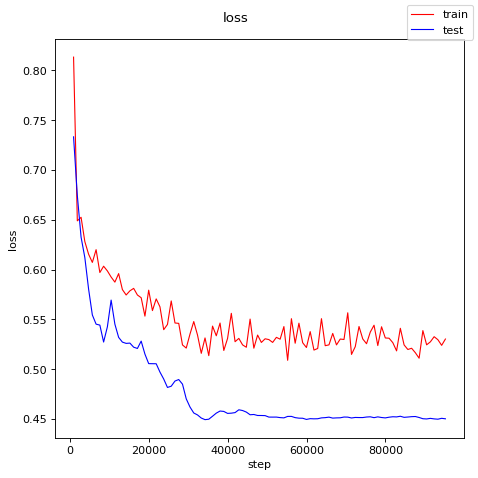

In [37]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(6, 6))

ax.plot(manager.trn_loss.x, manager.trn_loss.y, color='r', linewidth=1, label='train')
ax.plot(manager.tst_loss.x, manager.tst_loss.y, color='b', linewidth=1, label='test')

ax.set_xlabel('step')
ax.set_ylabel('loss')

fig.suptitle('loss')
fig.legend(loc='upper right')
fig.tight_layout()
fig

# test

In [38]:
manager_test = SampleModelManager(lr=0.001, device=torch.device('cpu'))
manager_test.load('data/model.pth')

In [39]:
actual, predicted = manager_test.sample(10000)

In [40]:
actual[:4]

[1.0, 1.0, 1.0, 1.0]

In [41]:
predicted[:4]

[0.6840732, 0.7844392, 0.9469261, 0.5227852]

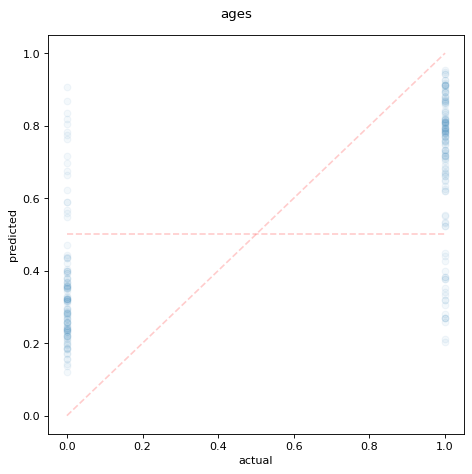

In [42]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(6, 6))

ax.scatter(actual, predicted, alpha=0.05)

ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='r', alpha=0.2)
ax.plot([0.0, 1.0], [0.5, 0.5], linestyle='--', color='r', alpha=0.2)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('actual')
ax.set_ylabel('predicted')

fig.suptitle('ages')
fig.tight_layout()
fig

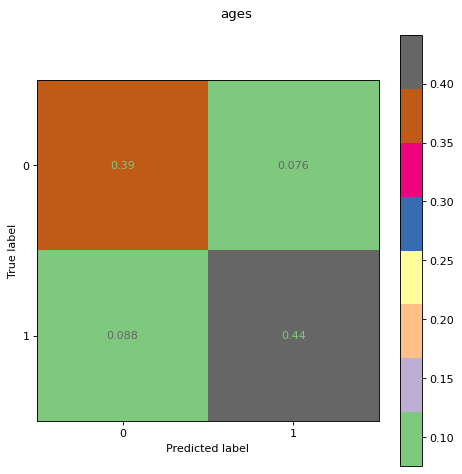

In [43]:
fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(6, 6))

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    [int(label >= 0.5) for label in actual], 
    [int(label >= 0.5) for label in predicted],
    ax=ax, normalize='all', cmap='Accent'
)


fig.suptitle('ages')
fig.tight_layout()
fig